In [4]:
# Prelab 

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rand
import time
import math
from scipy import io, integrate, linalg, signal
from scipy.linalg import lu_factor, lu_solve
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video
from mpl_toolkits.mplot3d import Axes3D
from timeit import default_timer as timer


In [5]:
def for_diff(f, s, h):
    return (f(s+h) -f(s)) / (h)

In [6]:
def cen_diff(f, s, h):
    return (f(s+h) -f(s-h)) / (2*max(h))

In [7]:
def logploterr(rn, r, label):
    n = rn.size-1; e = np.abs(r-rn[0:n]); nn = np.arange(0, n)
    plt.plot(nn, np.log2(e), label=label); plt.xlabel('n'); plt.ylabel('log2(error)')

In [8]:
def f(x): return np.cos(x)
h = 0.01*2.0**(-np.arange(0, 10))
s = np.pi / 2

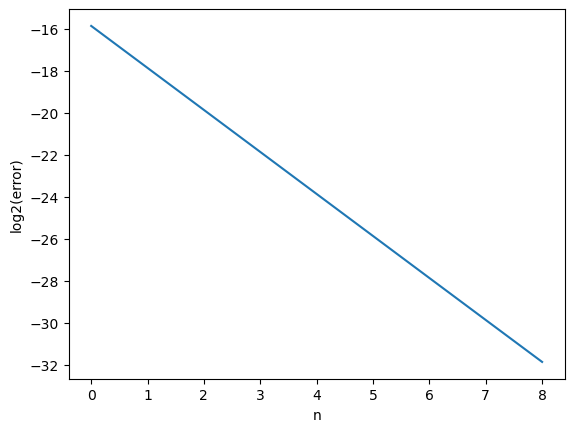

In [9]:
plt.figure()
logploterr(for_diff(f, s, h), -1, "forward difference")

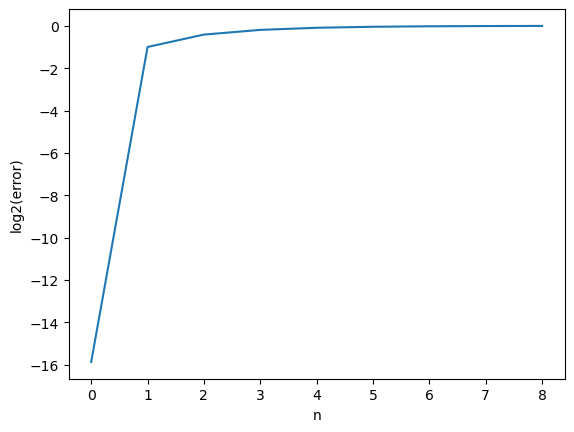

In [10]:
plt.figure()
logploterr(cen_diff(f, s, h), -1, "centered difference")

In [11]:
# Lab

In [12]:
def driver():
    ############################################################################
    ############################################################################
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.
    def F(x):
        return np.array([(x[0]-4)**2+2*(x[1]-2)**2-32 , x[1]*(x[0]-2)-16 ]);
    def JF(x):
        return np.array([[2*(x[0]-4),4*(x[1]-2)],[x[1],(x[0]-2)]]);

    # Apply Newton Method:
    x0 = np.array([4.0,4.0]); tol=1e-14; nmax=100;
    (rN,rnN,nfN,nJN) = newton_method_nd(F,JF,x0,tol,nmax,True);
    print(rN)

    # Apply Lazy Newton (chord iteration)
    nmax=1000;
    (rLN,rnLN,nfLN,nJLN) = lazy_newton_method_nd(F,JF,x0,tol,nmax,True);

    # Plots and comparisons
    numN = rnN.shape[0];
    errN = np.max(np.abs(rnN[0:(numN-1)]-rN),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='Newton');
    plt.title('Newton iteration log10|r-rn|');
    plt.legend();
    plt.show();

    numLN = rnLN.shape[0];
    errLN = np.max(np.abs(rnLN[0:(numLN-1)]-rN),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='Newton');
    plt.plot(np.arange(numLN-1),np.log10(errLN+1e-18),'r-o',label='Lazy Newton');
    plt.title('Newton and Lazy Newton iterations log10|r-rn|');
    plt.legend();
    plt.show();


In [13]:
# Newton method in n dimensions implementation
def newton_method_nd(f,Jf,x0,tol,nmax,verb=False):

    # Initialize arrays and function value
    xn = x0; #initial guess
    rn = x0; #list of iterates
    Fn = f(xn); #function value vector
    n=0;
    nf=1; nJ=0; #function and Jacobian evals
    npn=1;

    if verb:
        print("|--n--|----xn----|---|f(xn)|---|");

    while npn>tol and n<=nmax:
        # compute n x n Jacobian matrix
        Jn = Jf(xn);
        nJ+=1;

        if verb:
            print("|--%d--|%1.7f|%1.12f|" %(n,np.linalg.norm(xn),np.linalg.norm(Fn)));

        # Newton step (we could check whether Jn is close to singular here)
        pn = -np.linalg.solve(Jn,Fn);
        xn = xn + pn;
        npn = np.linalg.norm(pn); #size of Newton step

        n+=1;
        rn = np.vstack((rn,xn));
        Fn = f(xn);
        nf+=1;

    r=xn;

    if verb:
        if np.linalg.norm(Fn)>tol:
            print("Newton method failed to converge, n=%d, |F(xn)|=%1.1e\n" % (nmax,np.linalg.norm(Fn)));
        else:
            print("Newton method converged, n=%d, |F(xn)|=%1.1e\n" % (n,np.linalg.norm(Fn)));

    return (r,rn,nf,nJ);


In [14]:
# Lazy Newton method (chord iteration) without LU (solve is still n^3)
def lazy_newton_method_nd_simple(f,Jf,x0,tol,nmax,verb=False):

    # Initialize arrays and function value
    xn = x0; #initial guess
    rn = x0; #list of iterates
    Fn = f(xn); #function value vector
    n=0;
    nf=1; nJ=0; #function and Jacobian evals
    npn=1;

    if verb:
        print("|--n--|----xn----|---|f(xn)|---|");

    while npn>tol and n<=nmax:
        # compute n x n Jacobian matrix only if n==0
        if (n==0):
            Jn = Jf(xn);
            nJ+=1;

        if verb:
            print("|--%d--|%1.7f|%1.12f|" %(n,np.linalg.norm(xn),np.linalg.norm(Fn)));

        # Newton step
        pn = -np.linalg.solve(Jn,Fn);
        xn = xn + pn;
        npn = np.linalg.norm(pn); #size of Newton step

        n+=1;
        rn = np.vstack((rn,xn));
        Fn = f(xn);
        nf+=1;

    r=xn;

    if verb:
        if np.linalg.norm(Fn)>tol:
            print("Lazy Newton method failed to converge, n=%d, |F(xn)|=%1.1e\n" % (nmax,np.linalg.norm(Fn)));
        else:
            print("Lazy Newton method converged, n=%d, |F(xn)|=%1.1e\n" % (n,np.linalg.norm(Fn)));

    return (r,rn,nf,nJ);


In [15]:
# Lazy Newton method (chord iteration) in n dimensions implementation
def lazy_newton_method_nd(f,Jf,x0,tol,nmax,verb=False):

    # Initialize arrays and function value
    xn = x0; #initial guess
    rn = x0; #list of iterates
    Fn = f(xn); #function value vector
    # compute n x n Jacobian matrix (ONLY ONCE)
    Jn = Jf(xn);

    # Use pivoted LU factorization to solve systems for Jf. Makes lusolve O(n^2)
    lu, piv = lu_factor(Jn);

    n=0;
    nf=1; nJ=1; #function and Jacobian evals
    npn=1;

    if verb:
        print("|--n--|----xn----|---|f(xn)|---|");

    while npn>tol and n<=nmax:

        if verb:
            print("|--%d--|%1.7f|%1.12f|" %(n,np.linalg.norm(xn),np.linalg.norm(Fn)));

        # Newton step (we could check whether Jn is close to singular here)
        pn = -lu_solve((lu, piv), Fn); #We use lu solve instead of pn = -np.linalg.solve(Jn,Fn);
        xn = xn + pn;
        npn = np.linalg.norm(pn); #size of Newton step

        n+=1;
        rn = np.vstack((rn,xn));
        Fn = f(xn);
        nf+=1;

    r=xn;

    if verb:
        if np.linalg.norm(Fn)>tol:
            print("Lazy Newton method failed to converge, n=%d, |F(xn)|=%1.1e\n" % (nmax,np.linalg.norm(Fn)));
        else:
            print("Lazy Newton method converged, n=%d, |F(xn)|=%1.1e\n" % (n,np.linalg.norm(Fn)));

    return (r,rn,nf,nJ);

In [16]:
# Lazy Newton method (chord iteration) in n dimensions implementation
def slacker_newton_method_nd(f,Jf,x0,tol,nmax,verb=False):

    # Initialize arrays and function value
    xn = x0; #initial guess
    rn = x0; #list of iterates
    Fn = f(xn); #function value vector
    Jn = Jf(xn);

    n=0;
    nf=1; nJ=1; #function and Jacobian evals
    npn=1;

    npn_arr = np.array([npn])

    if verb:
        print("|--n--|----xn----|---|f(xn)|---|");

    while npn>tol and n<=nmax:

        if (n%4 == 2 ):
            Jn = Jf(xn)
            
        if verb:
            print("|--%d--|%1.7f|%1.12f|" %(n,np.linalg.norm(xn),np.linalg.norm(Fn)));

        # Newton step (we could check whether Jn is close to singular here)
        pn = -np.linalg.solve(Jn, Fn); 
        xn = xn + pn;
        npn = np.linalg.norm(pn); #size of Newton step
        npn_arr = np.append(npn_arr, npn)

        n+=1;
        rn = np.vstack((rn,xn));
        Fn = f(xn);
        nf+=1;

    r=xn;

    if verb:
        if np.linalg.norm(Fn)>tol:
            print("Lazy Newton method failed to converge, n=%d, |F(xn)|=%1.1e\n" % (nmax,np.linalg.norm(Fn)));
        else:
            print("Lazy Newton method converged, n=%d, |F(xn)|=%1.1e\n" % (n,np.linalg.norm(Fn)));

    return (r,rn,nf,npn_arr);

In [17]:
def f3_2(x):
    return np.array([(4*x[0]**2 + x[1]**2 -4), x[0] + x[1] - np.sin(x[0] - x[1])])
def Jf3_2(x):
    j11 = 8*x[0]
    j12 = 2*x[1]
    j21 = 1 - np.cos(x[0] - x[1])
    j22 = 1 + np.cos(x[0] - x[1])
    return np.array([[j11, j12], [j21, j22]])

|--n--|----xn----|---|f(xn)|---|
|--0--|1.0000000|0.158529015192|
|--1--|1.0052824|0.011528896267|
|--2--|1.0042309|0.000551674102|
|--3--|1.0041676|0.000000021567|
|--4--|1.0041676|0.000000000001|
Lazy Newton method converged, n=5, |F(xn)|=8.9e-16

[ 0.99860694 -0.10553049]


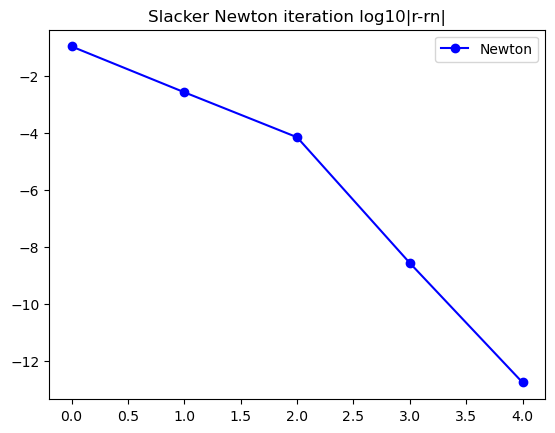

In [18]:

def driver3_2():
    ############################################################################
    ############################################################################
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Slacker Newton Method:
    x0 = np.array([1,0]); tol=1e-10; nmax=500;
    (rN,rnN,nfN,npn_arr) = slacker_newton_method_nd(f3_2,Jf3_2,x0,tol,nmax,True);
    print(rN)

    # Plots and comparisons
    numN = rnN.shape[0];
    errN = np.max(np.abs(rnN[0:(numN-1)]-rN),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='Newton');
    plt.title('Slacker Newton iteration log10|r-rn|');
    plt.legend();
    plt.show()

driver3_2()

In [19]:
def cen_diff_nd(f, s, h, num_inputs, num_outputs):
    J_aprox_T = np.zeros([num_inputs, num_outputs])

    for i in range(num_inputs):
            h_vec = np.zeros([num_outputs])
            h_vec[i] = h*np.linalg.norm(s)
            J_aprox_T[i] = cen_diff(f, s, h_vec).T

    return J_aprox_T.T

|--n--|----xn----|---|f(xn)|---|
|--0--|1.0000000|0.158529015192|
|--1--|1.0052824|0.011528896263|
|--2--|1.0041694|0.000014569429|
|--3--|1.0041676|0.000000000013|
Newton method converged, n=4, |F(xn)|=4.6e-16

[ 0.99860694 -0.10553049]


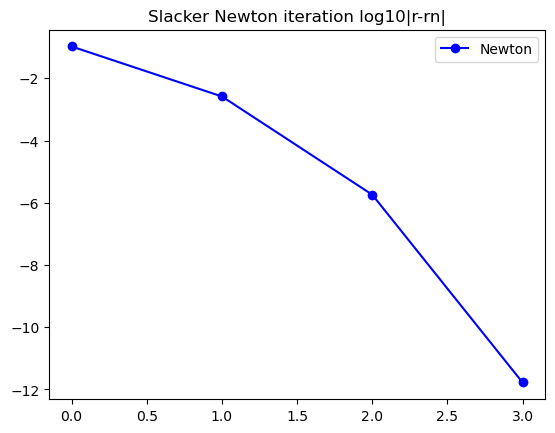

In [20]:
def driver3_3(h):
    ############################################################################
    ############################################################################
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.
    Jf_aprox = lambda x : cen_diff_nd(f3_2, x, h, 2, 2)

    # Apply Slacker Newton Method:
    x0 = np.array([1,0]); tol=1e-7; nmax=500;
    (rN,rnN,nfN,nJ) = newton_method_nd(f3_2,Jf_aprox,x0,tol,nmax,True);
    print(rN)

    # Plots and comparisons
    numN = rnN.shape[0];
    errN = np.max(np.abs(rnN[0:(numN-1)]-rN),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='Newton');
    plt.title('Slacker Newton iteration log10|r-rn|');
    plt.legend();
    plt.show()

driver3_3(1e-7)

|--n--|----xn----|---|f(xn)|---|
|--0--|1.0000000|0.158529015192|
|--1--|1.0052824|0.011528893959|
|--2--|1.0041694|0.000014569400|
|--3--|1.0041676|0.000000000013|
Newton method converged, n=4, |F(xn)|=8.9e-16

[ 0.99860694 -0.10553049]


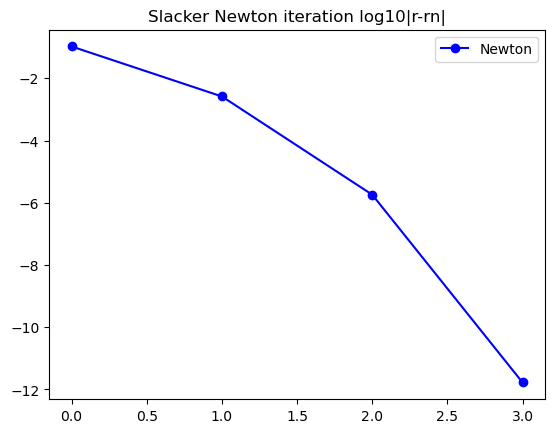

In [21]:
driver3_3(1e-3)

In [30]:
def iter(f, df, x0, TOL, NMAX):
    rn = np.array([x0])
    n = 0
    while (n < NMAX):
        fx = f(x0)
        dfx = df(x0)
        x0 = x0 -(f(x0)/ np.linalg.norm(df(x0))**2)*df(x0)
        rn = np.vstack((rn, x0))
        n += 1
        if (np.linalg.norm(rn[-1] - rn[-2]) < TOL):
            return rn

In [31]:
def f_3(x_vec):
    (x,y, z) = x_vec
    return x**2+4*y**2 + 4*z**2 -16

def df_3(x_vec):
    (x,y, z) = x_vec
    df1 = 2*x
    df2 = 8*y
    df3 = 8*z
    return np.array([df1,df2,df3])

In [32]:
x0 = np.array([1,1,1])


[[1.         1.         1.        ]
 [1.10606061 1.42424242 1.42424242]
 [1.09392616 1.36174169 1.36174169]
 [1.09364246 1.36032911 1.36032911]
 [1.09364232 1.36032838 1.36032838]
 [1.09364232 1.36032838 1.36032838]
 [1.09364232 1.36032838 1.36032838]]


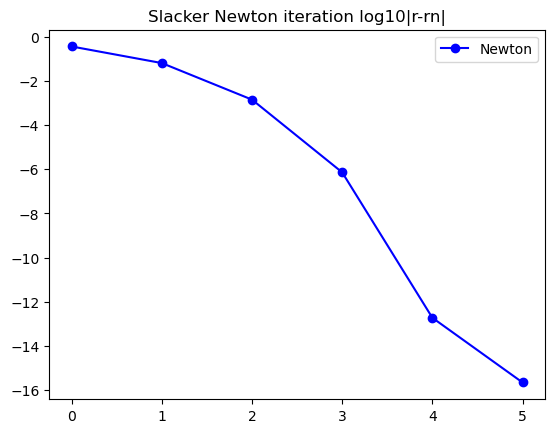

In [33]:
def driver3_2():
    ############################################################################
    ############################################################################
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Slacker Newton Method:
    x0 = np.array([1,1,1]); TOL=1e-15; NMAX=500;
    rn = iter(f_3, df_3, x0, TOL, NMAX)
    
    print(rn)
    
    # Plots and comparisons
    numN = rn.shape[0];
    errN = np.max(np.abs(rn[0:(numN-1)]-rn[-1]),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='Newton');
    plt.title('Slacker Newton iteration log10|r-rn|');
    plt.legend();
    plt.show()

driver3_2()